# Monte Carlo Bayes Parameter Inference


In this notebook, we do parameter inference in statistical models using Bayes approach. We do this for 

 * Unsupervised Leaning
 * Supervised Learning
   * Classification
   * Regression
 

## Theory

### Unsupervised Learning

In the case of unsupervised learning, we have a data generating process represented by a random variable $X$. $X$ can be

 * $X: (\Omega, A, P) \rightarrow (ℝ^n, B(ℝ^n), P')$
 * $X: (\Omega, A, P) \rightarrow (ℕ^n, P(ℕ^n), P')$
 
In either case, we assume that $P'$ is parametrized by $\theta \in \Theta$ and we have a statistical model $\mathbf{P} = \{P_{\theta} | \theta \in \Theta\}$. In this notebook, given data from the data generating process, we use Bayes inference statistic to estimate $\theta$.


### Supervised Learning

In the case of supervised learning, we have a data generating process represented by a random variable $Z$ with distribution $P_Z'$. We assume that there are random variables $X$ and $Y$ with distributions $P_X'$ and $P_Y'$ such that $P' = P_X' \times P_Y'$.

 * $Z: (\Omega, A, P) \rightarrow (\alpha^n \times \beta, B(\alpha^n \times \beta), P')$
 * $X: (\Omega, A, P) \rightarrow (\alpha^n, B(\alpha^n), P_X')$
 * $Y: (\Omega, A, P) \rightarrow (\beta, B(\beta), P_Y')$

where

 * Continuous to continuous: $\alpha = ℝ$, $\beta = ℝ$ 
 * Continuous to discrete: $\alpha = ℝ$, $\beta = ℕ$
 * Discrete to discrete: $\alpha = ℕ$, $\beta = ℕ$
 * Discrete to continuous: $\alpha = ℕ$, $\beta = ℝ$
 
We are now interest in the deterministic function 

$$ f: \alpha^n \rightarrow \beta; f(x_1, ..., x_n) \rightarrow \mathbf{E}[Y | X = (x_1, ..., x_n)] = \int_Y y p(y | x_1, ..., x_n) dy$$ 

We assume that $f$ is parametrized by $\theta \in \Theta$ and we have $\mathbf{F} = \{f_{\theta} | \theta \in \Theta\}$. In this notebook, given data from the data generation process, we use Bayes inference statistics to estimate $\theta$.

Note that we could also use a different statistical inference approach to estimate $\theta$, like e.g. maximum likelihood estimation. Remember $\hat{\theta}_{MAP}$ and $\hat{\theta}_{MLE}$.

$$ \hat{\theta}_{MAP} = \underset{\theta\ \in \Theta}{argmax}{p(\theta | x_i, ..., x_m)} $$

$$ \hat{\theta}_{MLE} = \underset{\theta\ \in \Theta}{argmax}{L(x_i, ..., x_m; \theta)} $$

where $x_1, ... x_m$ are $m$ observations from the data generating process and $L$ is the likelihood function. In the case of maximum likelihood inference, $L$ is not a probability distribution and thus can't be investigated through sampling approaches - like Markov Chain Monte Carlo methods - as easily as $p(\theta | x_1, ..., x_m)$.



## Applications

For the applications in this notebook, we use the probabilistic programming library PyMC3.

### Unsupervised Learning

#### Coin Toss

We have a coin that we toss. The coin can come up either head or tail. We throw the coin $m = 10$ times and observe head $h = 6$ times. We want to estimate the probability that the coin comes up head indicated by the parameter $\theta \in [0, 1]$. The data $x_1, ..., x_m$, in this case, can be indicated simply by $h$ and $m$.

We assume a beta distribution as marginal distribution over $\theta$

$$ p(\theta; a, b) = \theta^{\alpha - 1}(1-\theta)^{\beta -1} $$

And a binomial distribution as the conditional distribution of the data ($h, m$) given $\theta$

$$ p(h | \theta) = B(m, \theta)$$

Note that the the joint distribution $p(h, \theta)$ exists. Through  chain rule of probability we can define the joint distribution by a product of a marginal beta distribution $p(\theta)$ and a conditional binomial distribution $p(h | \theta)$.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pymc3.distributions import InverseGamma, Normal
import pymc3 as pm
import scipy.stats as stats

In [7]:
m = 10  # number of trials
h = 6  # number of successes
alpha = 10  # hyperparameter of beta prior
beta = 10  # hyperparameter of beta prior

niter = 1000

with pm.Model() as model:
    p = pm.Beta('p', alpha=alpha, beta=beta)  # prior
    y = pm.Binomial('y', n=m, p=p, observed=h)  # likelihood
    start = pm.find_MAP()  # use MAP estimate as init for MCMC
    step = pm.Metropolis() # use Metropolis sampler
    trace = pm.sample(niter, step, start, chains=2, random_seed=123, progressbar=True)

logp = -0.32478, ||grad|| = 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1523.55draws/s]


We started two Markov chains to sample from the posterior, each to run for a 1000 steps. As a sampler, we used the PyMC3 Metropolis sampler. Note that we initialized the chains with $\hat{\theta}_{MAP}$. If $\hat{\theta}_{MAP}$ can be calculated easily it's a good start point. Let's plot the random samples in the two Markov chains along with the prior and the true posterior.

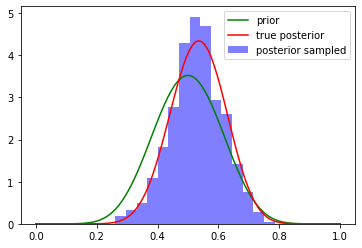

In [13]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), color='green', label='prior');
plt.plot(x, stats.beta.pdf(x, h+alpha, m-h+beta), color='red', label='true posterior');
plt.hist(trace['p'], 15, color='blue', alpha=0.5, density=True, label='posterior sampled');
plt.legend();

We see that samples from the Markov chains are close to the true posterior. Next, let's have a look at a couple of diagnostics plots, which help us to understand whether our sampling process has converged or not. 

C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


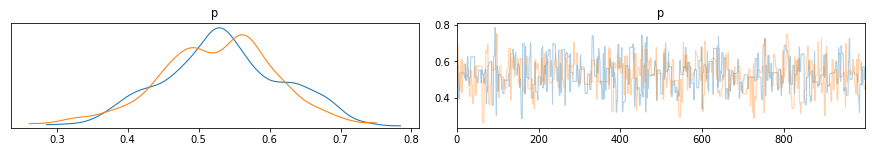

In [9]:
pm.traceplot(trace);

The default `traceplot` shows shows on the left side the estimated density of the posterior for each of the chains (by means of a kernel density estimator). On the right side, it shows the samples in each of the chains. 

In [10]:
pm.summary(trace).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.529,0.086,0.373,0.692,0.004,0.003,507.0,507.0,510.0,440.0,1.0


`summary` prints a summary table including

* mean: the mean parameter value across all chains
* sd: the standard deviation, probably across all chains
* hpd_3%: lower bound of the the highest posterior density 0.94 credible interval
* hpd_97%: upper bound of the the highest posterior density 0.94 credible interval
* mcse_mean: the mean of Markov chain standard error
* mcse_sd: the standard deviation of the Markov chain standard error
* ess_mean: the effective sample size, with $ess = \frac{n}{1 + 2\sum_{k=1}^{\infty}\rho(k)}$ 
  and $\rho(k)$ the autocorrelation at lag $k$, The smaller the better
* r_hat: compares between- and within-chain estimates for model parameters. If chains did not mix well i.e. between- and within-chain estimates don't agree, R-hat is larger than 1

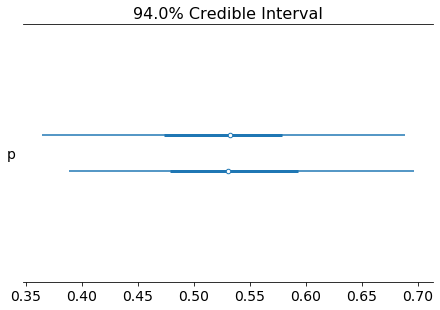

In [15]:
pm.forestplot(trace);

The `forestplot` shows the highest posterior density credible interval for all chains combined and for each chain individually. Besides, it shows quartile ranges for the individual chains.

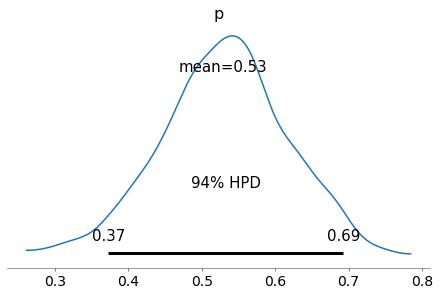

In [16]:
pm.plot_posterior(trace);

PyMC3 also offers other samplers. An overview can be found in pm.step_methods.

`plot_posterior`, finally, is a summary plot that shows the estimated density and its mean of the parameter under investigation as well as the 94% highest posterior density credible interval.

Besides, PyMC3 offers a couple of sampler beside the Metropolis sampler, which we used here.

In [17]:
[m for m in dir(pm.step_methods) if m[0].isupper()]

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

#### Estimating Parameters of Normal Distribution

Let's assume that we have a random variable $Z$ that has distribution over variables $x$, $\mu$ such that the conditional distribution $p(x | \mu; \sigma^2)$ has a univariate normal distribution $\mathcal{N}(\mu, \sigma^2)$ with 

$$ p(x | \mu; \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2} $$

And the marginal distribution $p(\mu)$ has a univariate normal distribution $\mathcal{N}(0, 1)$ with 

$$ p(\mu) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\mu^2} $$

We can calculate the joint distribution like 

$$ p(x, \mu) = p(x | \mu) p(\mu) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2} \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\mu^2} = \frac{1}{2\pi\sigma}e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2 -\frac{1}{2}\mu^2} $$
     
Probably, this represents a bivariate normal distribution and, consequentially, $p(\mu | x)$ would also be normal. It actually doesn't even matter that much what kind of distribution $p(x, \mu)$ and $p(\mu | x)$ are. More important is that they exists and we know that $p(x, \mu)$ exists since $p(x, \mu) = p(x | \mu)p(\mu)$ and consequently also $p(\mu | x)$ exists. That means, we can sample from $p(\mu | x)$.

Note that we assume that $\sigma^2$ is non-random and for the sampling we use $\mu = 5$ and $\sigma = 2$.

In [33]:
mu_real = 5
sd_real = 2
x = np.random.normal(mu_real, sd_real, 1000)

with pm.Model() as model:
    prior = pm.Normal('mu', mu=0, sd=1)
    likelihood = pm.Normal('likelihood', mu=prior, sd=2, observed=x)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start=start, chains=4, random_seed=5643, progressbar=True)

logp = -5,143.8, ||grad|| = 1,232: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 401.02it/s]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42000/42000 [00:17<00:00, 2432.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C44D17CD08>],
      dtype=object)

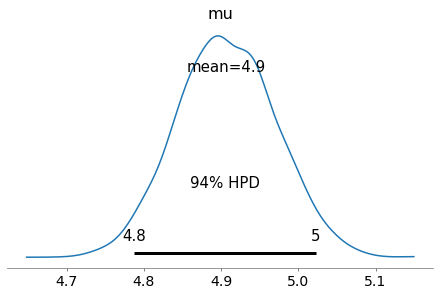

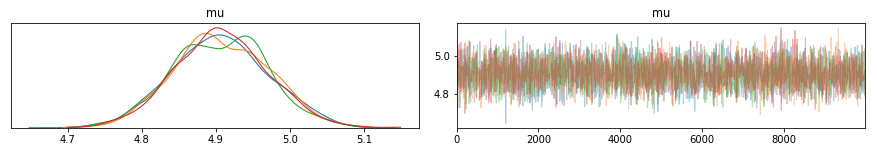

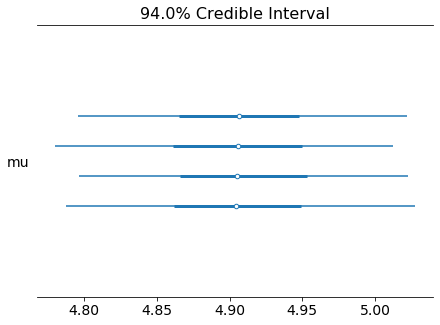

In [35]:
pm.plot_posterior(trace)
pm.traceplot(trace)
pm.forestplot(trace);

In [36]:
pm.summary(trace).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.907,0.063,4.788,5.023,0.001,0.001,3638.0,3638.0,3674.0,3894.0,1.0


### Supervised Learning

#### Linear Regression

Let's assume we have a data generating process that is described by the two random variables $X$ and $Y$ that have a shared distribution described by the random variable $Z = (X, Y): (\Omega, A, P) \rightarrow (ℝ^2, B(ℝ^2))$. 

We assume that the random variable $Z$ imposes a linear relationship between $X$ and $Y$ of the form 

$$ (Y | X = x) \sim ax + b + \mathcal{N}(0, \sigma^2), \forall x $$

For some $a, b, \sigma^2 \in ℝ$. Given $n$ independent and identically drawn samples $(z)_{i = 1}^n = (x, y)_{i=1}^n$ from the data generating process, we want to find $\theta = (a, b, \sigma^2)$ such that

$$ f_{a, b}: ℝ \rightarrow ℝ; x \rightarrow f_{a, b}(x) = E[Y | X = x] = ax + b, \forall x $$ 

We want to find $\theta$ by Monte Carlo Bayesian parameter inference. For this purpose, we need an expression for the distribution of $\theta$ under $(Z)_{i=1}^n = (z)_{i = 1}^n$. This is, we need 

$$ p(\theta | Z_{i=1}^n = z_{i = 1}^n) $$

Since we are in the Bayesian inference setting we have 

$$ p(\theta | z_{i = 1}^n) = \frac{p(z_{i = 1}^n | \theta)p(\theta)}{p(z_{i = 1}^n)} $$

And since we are going to use the Metropolis-Hastings sampling algorithm it's enough to have

$$ p(\theta | z_{i = 1}^n) \propto p(z_{i = 1}^n | \theta)p(\theta) $$

Let's first look at 

$$ p(z_{i = 1}^n | \theta) = p((x, y)_{i = 1}^n | \theta) $$ 

first. The parameter $\theta = (a, b, \sigma^2)$ describes the conditional distribution of $Y$ given $X = x$. This means, that we partly describe the joint distribution $Z = (X, Y)$ through the conditional distribution $Y | X =x $. The parameter $\theta$, however, doesn't say anything about the distribution of $X$. To fully describe $p(z_{i = 1}^n | \theta) = p((x, y)_{i = 1}^n | \theta)$ we need the marginal distribution of $X$ under $\theta$. This is, $p(x_{i=1}^n) | \theta$. The we can describe $p(z_{i = 1}^n | \theta)$ using the chain rule of probability like

$$ p(z_{i = 1}^n | \theta) = p((x,y)_{i = 1}^n | \theta) = p(y_{i = 1}^n | x, \theta) p(x_{i=1}^n | \theta) $$

However, often in the supervised learning setting where we have a random variable $X$, which describes the independent variables and we have a random variable $Y$, which describes the dependent variable, we assume that $X$ is actually not random. This is, we set

$$ p(z_{i = 1}^n | \theta) = p(y_{i = 1}^n | \theta; x_{i=1}^n) $$

And consequently we sample from

$$ p(\theta | y_{i = 1}^n; x_{i=1}^n) \propto p(y_{i = 1}^n | \theta; x_{i=1}^n)p(\theta) $$

From a technical point of view, treating $X$ as deterministic makes our life easier because we have one level of randomness less, which we need to take into consideration. Treating $X$ as random might make sense if we have some justified assumption about the distribution of $X$. For the examples here, and probably for most applications of Bayesian parameter inference in supervised learning settings, $X$ is treated as deterministic. I could imagine that this approach leads to some some kind of underestimation of uncertainty in the Bayesian inference setting. How severe that is is difficult for me to say at this point. 


Note that treating $X$ as uniformly distributed over some interval $[c, d] \in ℝ$ and calculating the marginal distribution $p(y_{i=1}^n | \theta)$ wouldn't work because we  would have 

$$ p(y_{i=1}^n | \theta) = \int_c^d{p(y_{i=1}^n | x_{i=1}^n, \theta) p(x_{i=1}^n | \theta)}dx = \int_c^d{p(y_{i=1}^n | x_{i=1}^n, \theta)}dx = const + \mathcal{N(0, \sigma^2)}$$

This is, integrating out $x_{i=1}^n$ would leave us with the marginal distribution for $y_{i=1}^n$ in which the linear relationship between $X$ and $Y$ would have gotten lost.

Now, let's look at the marginal distribution for $\theta$ 

$$ p(\theta) $$

We have to specify this for our parameter $\theta = (a, b, \sigma^2)$ in order to sample from $p(\theta | x_{i=1}^n)$. This is the prior knowledge about our data generating process, which is a component that is mandatory to specify in the Bayesian inference setting. 

Now let's assume that we are in the setting describe above. This is, we have a data generating process where $(Y | X = x) \sim ax + b + \mathcal{N}(0, \sigma^2)$ and we want to infer $\theta = (a, b, \sigma^2$). In this example, we assume that $a = 6$, $b = 2$, and $\sigma^2 = 1$. We want to infer those parameters and the uncertainty associated with the estimations using Monte Carlo Bayesian parameter inference. We sample ten data points $(z)_{i=1}^{10} = (x, y)_{i=1}^{10}$ with $(x)_{i=1}^{10}$ non-randomly and evenly spaced between $[0, 1]$ 

In [1]:
np.random.seed(6391)

n = 10
a_true = 6
b_true = 2
x = np.linspace(0, 1, n)
y = a_true*x + b_true + np.random.randn(n)

plt.scatter(x, y, c='blue', label="samples drawn from DGP")
plt.plot(x, a_true*x + b_true, c='red', label='$ax + b$')
plt.legend()

NameError: name 'np' is not defined

In [1]:
samples = 10
with pm.Model() as model1:
    # Priors
    s = InverseGamma('s', 2, 3)
    a = Normal('a', 0, sd=10)
    b = Normal('b', 0, sd=10)

    likelihood = Normal('y', mu=a*x + b, sd=np.sqrt(s), observed=y)

    trace = pm.sample(samples, chains=4) 


pm.traceplot(trace)

NameError: name 'pm' is not defined

C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda3\envs\fun_monte_carlo_methods\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\pkaiser\AppData\Local\Continuum\anaconda

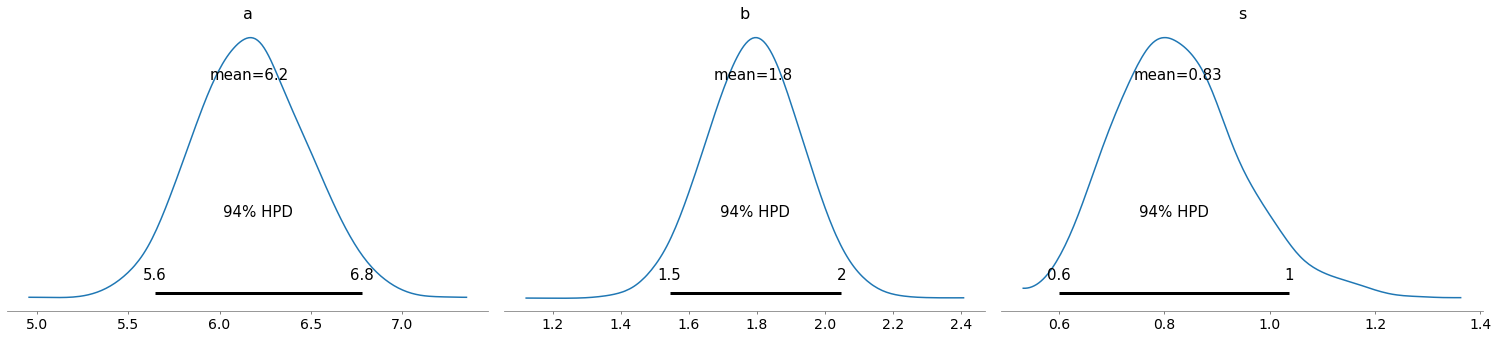

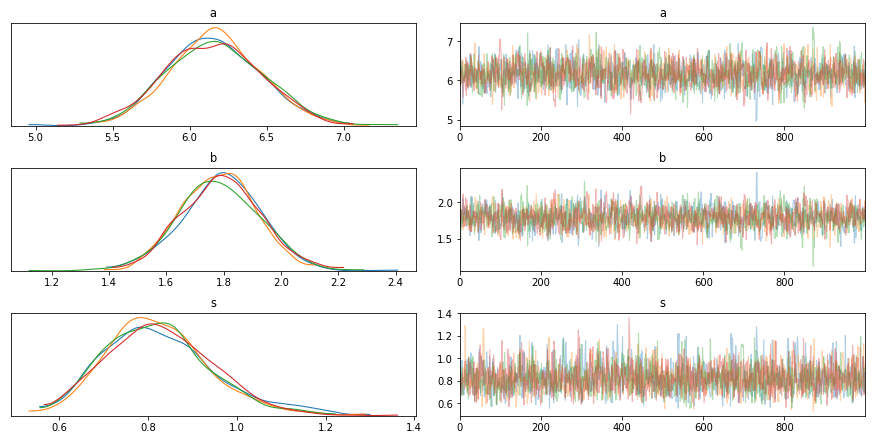

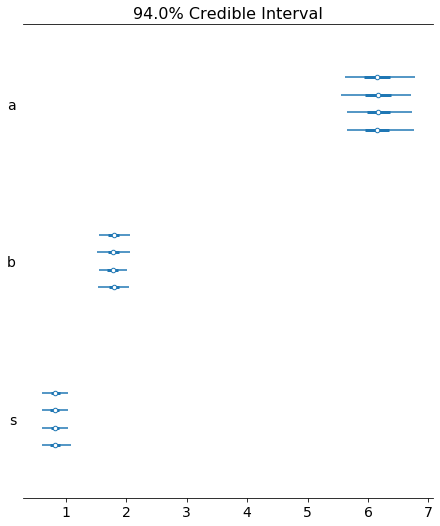

In [6]:
pm.plot_posterior(trace)
pm.traceplot(trace)
pm.forestplot(trace);

#### Binomial Likelihood

#### Bayesian Neural Networks

#### LSTM Cell

The specific architecture used in this implementation is as described in "Learning to Execute" [2], reproduced below: 

* Input gage $g_t := W_{hg} \times h_{t-1} + W_{xg} \times x_t + b_g$
* External input gate $i_t := W_{hi} \times h_{t-1} + W_{xi} \times x_t + b_i$
* Forget gate $f_t := W_{hf} \times h_{t-1} + W_{xf} \times x_t + b_f$
* Output gate $o_t := W_{ho} \times h_{t-1} + W_{xo} \times x_t + b_o$
* Cell internal state (before applying output gate) $c_t := (f_t .* c_{t-1}) + (i_t .* g_t)$
* Hidden state after (applying output gate) $h_t := o_t .* c_t$

In the implementation, the $i$, $f$, $o$, and $g$ computations are performed as a single inner product.